To extract the statistics used by sync linear moves

Example start to finish:

2022-06-14 08:43:24,841 - app.exe - INFO - Executing Robot-Clamp Linear Sync Move to Frame(Point(20861.239, 10260.262, 1832.719), Vector(0.000, 0.985, -0.174), Vector(1.000, -0.000, 0.000)). Clamps ['c3', 'c1'] Jaw Move to [100, 100]. (A113_M3): Robot and Clamps (['c3', 'c1']) syncronously move to clamp Beam ('b11')

2022-06-14 08:43:43,462 - app.exe - WARNING - Sync Lost: Clamp Command Failed.

2022-06-14 08:43:43,467 - app.run - INFO - Execution Error. Program Stopped. Run Thread Ended.

2022-06-14 08:44:54,338 - app.exe - INFO - Executing Robot-Clamp Linear Sync Move to Frame(Point(20861.239, 10260.262, 1832.719), Vector(0.000, 0.985, -0.174), Vector(1.000, -0.000, 0.000)). Clamps ['c3', 'c1'] Jaw Move to [100, 100]. (A113_M3): Robot and Clamps (['c3', 'c1']) syncronously move to clamp Beam ('b11')


2022-06-14 08:49:54,688 - app.exe - INFO - RobClamp Sync Move Completed


In [1]:
from process_controller_logs.functions import *

from datetime import datetime

log_lines = []
file_path = r"C:\Users\leungp\Documents\GitHub\integral_timber_joints\external\itj_design_study\220407_CantiBoxMid\execution_log\ProcessExeController.2022-06-13.debug.log"
log_lines += load_log(file_path)
file_path = r"C:\Users\leungp\Documents\GitHub\integral_timber_joints\external\itj_design_study\220407_CantiBoxMid\execution_log\ProcessExeController.2022-06-14.debug.log"
log_lines += load_log(file_path)

num_lines = len(log_lines)
print(f"Total Number of lines read from log file: {num_lines}")  # print number of lines


valid_lines = filter_valid_log_lines(log_lines)
num_valid_lines = len(valid_lines)  # get the number of lines read
print(f"Number of valid lines read from log file: {num_valid_lines}")  # print number of lines

json_path = r"C:\Users\leungp\Documents\GitHub\integral_timber_joints\external\itj_design_study\220407_CantiBoxMid\CantiBoxMid_process.json"
process = load_process(json_path)

Number of lines read from log file: 41362
Number of lines read from log file: 84448
Total Number of lines read from log file: 125810
Number of valid lines read from log file: 125810
Process Loaded (28 Beams, 228 Actions, 1119 Movements)


In [21]:
# Search for lines with a Movement ID and total time.
from datetime import timedelta
from collections import OrderedDict
import re

pattern = r"\((A\d+_M\d+)\).* total time (.*) s"  # regular expression pattern to match (A1_M0) and the time

current_m_id = ""
current_start_time = ""
movement_time_dict = OrderedDict()
for time, app, scope, message in valid_lines:
    # Search for the begining of an action
    pattern = r"Executing.* \((A\d+_M\d+)\)"  # regular expression pattern to match (A1_M0) and the time
    result = re.search(pattern, message)
    if result is not None:
        m_id = result.group(1)

        if m_id != current_m_id:
            print (m_id, time, message) 
            if current_start_time != "":
                delta_time = time - current_start_time
                movement_time_dict[current_m_id] = delta_time

            current_start_time = time
            current_m_id = m_id
        

# print(movement_time_dict)
# print(f"Total Duration = {total_duration_s} s")

A0_M1 2022-06-13 09:33:58.689000 Executing Linear Move to Frame(Point(23479.276, 3236.560, 1021.685), Vector(0.000, 1.000, -0.000), Vector(1.000, -0.000, 0.001)) (A0_M1): Linear Advance to Storage Frame of PG1500 ('g3'), to get tool.

A0_M2 2022-06-13 09:34:01.715000 Executing IO LockTool (A0_M2): Toolchanger Lock PG1500 ('g3')

A0_M3 2022-06-13 09:34:02.423000 Executing Linear Move to Frame(Point(23479.047, 3236.618, 1271.684), Vector(0.000, 1.000, -0.000), Vector(1.000, -0.000, 0.001)) (A0_M3): Linear Retract after getting PG1500 ('g3') from storage.

A1_M0 2022-06-13 09:34:16.357000 Executing Load Beam ('b1') for pickup at Frame(Point(25277.983, 10347.224, 574.525), Vector(0.000, -1.000, 0.008), Vector(-0.000, 0.008, 1.000)) (Side 4 face up). (A1_M0): Opeartor Load Beam (b1) to Pickup Location

A2_M0 2022-06-13 09:34:21.248000 Executing Free Move to Frame(Point(24804.149, 8766.941, 637.717), Vector(-0.000, 0.008, 1.000), Vector(0.000, -1.000, 0.008)) (A2_M0): Free Move to reach Pick

{'RoboticFreeMovement': 156, 'RoboticLinearMovement': 400, 'RoboticDigitalOutput': 248, 'OperatorLoadBeamMovement': 28, 'SetWorkpieceWeight': 50, 'CancelRobotOffset': 94, 'ClampsJawMovement': 45, 'AcquireDockingOffset': 56, 'RoboticClampSyncLinearMovement': 14, 'OperatorAttachToolMovement': 8, 'RobotScrewdriverSyncLinearMovement': 16, 'ScrewdriverMovement': 4}


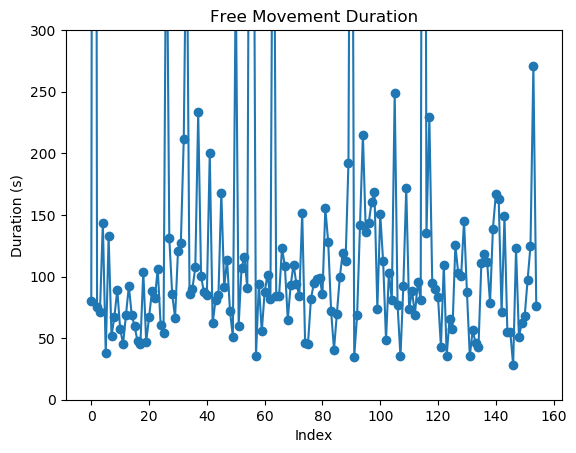

42.2827 366.1069999999988
Mean Value discarding top bottom 5% = 102.17128776978417


In [7]:
import matplotlib.pyplot as plt


x = []  # create list of indices for x-axis
y = []  # create list of duration_s for y-axis
index = 0
for m_id, duration in movement_time_dict.items():
    movement = process.get_movement_by_movement_id(m_id) 
    if movement.__class__.__name__ == "RoboticFreeMovement":
        x.append(index)
        index +=1
        y.append(duration.total_seconds())

plt.plot(x, y)  # plot the values of duration_s
plt.scatter(x, y)  # display the data points as dots
plt.xlabel('Index')  # add label for x-axis
plt.ylabel('Duration (s)')  # add label for y-axis
plt.title('Free Movement Duration')  # add title for the plot
plt.ylim(0, 300)  # set the y-axis limits

plt.show()  # show the plot

mean = mean_percentile(y,5,95)
print (f"Mean Value discarding top bottom 5% = {mean}")


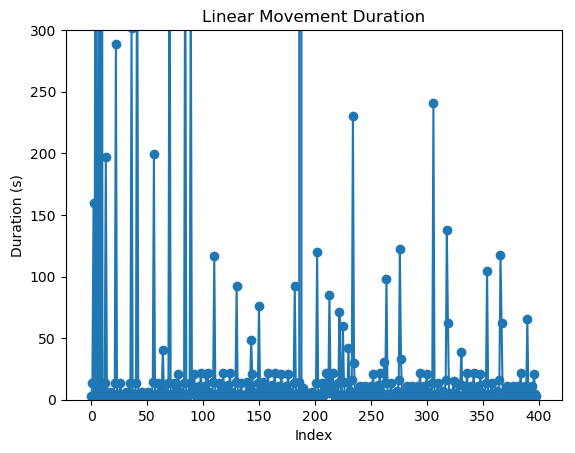

2.3973 106.0524999999996
Mean Value discarding top bottom 5% = 9.946696378830083


In [8]:
import matplotlib.pyplot as plt


x = []  # create list of indices for x-axis
y = []  # create list of duration_s for y-axis
index = 0
for m_id, duration in movement_time_dict.items():
    movement = process.get_movement_by_movement_id(m_id) 
    if movement.__class__.__name__ == "RoboticLinearMovement":
        x.append(index)
        index +=1
        y.append(duration.total_seconds())

plt.plot(x, y)  # plot the values of duration_s
plt.scatter(x, y)  # display the data points as dots
plt.xlabel('Index')  # add label for x-axis
plt.ylabel('Duration (s)')  # add label for y-axis
plt.title('Linear Movement Duration')  # add title for the plot
plt.ylim(0, 300)  # set the y-axis limits

plt.show()  # show the plot

mean = mean_percentile(y,5,95)
print (f"Mean Value discarding top bottom 5% = {mean}")

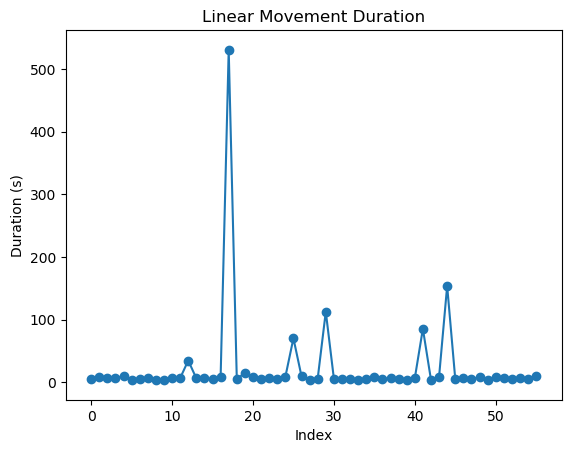

4.17425 92.24225
Mean Value discarding top bottom 5% = 10.07006


In [26]:
import matplotlib.pyplot as plt


x = []  # create list of indices for x-axis
y = []  # create list of duration_s for y-axis
index = 0
for m_id, duration in movement_time_dict.items():
    movement = process.get_movement_by_movement_id(m_id) 
    if movement.__class__.__name__ == "AcquireDockingOffset":
        x.append(index)
        index +=1
        y.append(duration.total_seconds())

plt.plot(x, y)  # plot the values of duration_s
plt.scatter(x, y)  # display the data points as dots
plt.xlabel('Index')  # add label for x-axis
plt.ylabel('Duration (s)')  # add label for y-axis
plt.title('Linear Movement Duration')  # add title for the plot
# plt.ylim(0, 10)  # set the y-axis limits

plt.show()  # show the plot

mean = mean_percentile(y,5,95)
print (f"Mean Value discarding top bottom 5% = {mean}")